In [1]:
# on-policy first-visit MC Control, SARSA, Q-Learning

In [2]:
import warnings ; warnings.filterwarnings('ignore')

import itertools
import gym, gym_walk, gym_aima
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [4]:
def value_iteration(P, gamma=1.0, theta=1e-10):
    V = np.zeros(len(P), dtype=np.float64)
    while True:
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64)
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
        V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi

In [5]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [6]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [7]:
def print_action_value_function(Q, 
                                optimal_Q=None, 
                                action_symbols=('<', '>'), 
                                prec=3, 
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'err')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [8]:
def probability_success(env, pi, goal_state, iterations=1000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        while not done:
            state, _, done, _ = env.step(pi(state))
        results.append(state == goal_state)
    return np.sum(results)/len(results)

In [9]:
def mean_return(env, pi, iterations=1000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        results.append(0.0)
        while not done:
            state, reward, done, _ = env.step(pi(state))
            results[-1] += reward
    return np.mean(results)

In [10]:
def regret_accumulation(env, pi, optimal_Q, iterations=10):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        results.append(0.0)
        while not done:
            action = pi(state)
            regret = np.max(optimal_Q[state]) - optimal_Q[state][action]
            state, reward, done, _ = env.step(action)
            results[-1] += regret
    return np.mean(results)

In [11]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

In [12]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [13]:
def plot_value_function(title, V_track, V_true=None, log=False):
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []
    for i, state in enumerate(V_track.T):
        if not (V_true is None) and V_true[i] < 0.1:
            continue
        line_type = next(linecycler)
        label = 'Estimated V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
        if not (V_true is None):
            label = 'True v({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center left', bbox_to_anchor=(1.1+loc*0.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes')
    plt.show()

In [14]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, t):
    decay_steps = int(max_steps * decay_ratio) - 2
    rem_steps = max_steps - decay_steps - 2
    values = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
    values = values * (init_value - min_value) + min_value   
    values = np.hstack((init_value, values, min_value)) 
    values = np.pad(values, (0, rem_steps), 'edge')
    return values[t]

In [15]:
env = gym.make('SlipperyWalkSeven-v0')
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=0.99)
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='Optimal action-value function:')
print()

print_policy(optimal_pi, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%. Obtains an average undiscounted return of {:.4f}.'.format(
    probability_success(env, optimal_pi, goal_state=8)*100, 
    mean_return(env, optimal_pi)))

Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |

Optimal action-value function:
╒═════╤════════╤════════╕
│   s │      < │      > │
╞═════╪════════╪════════╡
│   0 │ 0      │ 0      │
├─────┼────────┼────────┤
│   1 │ 0.3119 │ 0.5637 │
├─────┼────────┼────────┤
│   2 │ 0.6703 │ 0.763  │
├─────┼────────┼────────┤
│   3 │ 0.8032 │ 0.8449 │
├─────┼────────┼────────┤
│   4 │ 0.8638 │ 0.8892 │
├─────┼────────┼────────┤
│   5 │ 0.9014 │ 0.922  │
├─────┼────────┼────────┤
│   6 │ 0.9322 │ 0.9515 │
├─────┼────────┼────────┤
│   7 │ 0.9613 │ 0.9806 │
├─────┼────────┼────────┤
│   8 │ 0      │ 0      │
╘═════╧════════╧════════╛

Policy:
|           | 01      > | 02      > | 03      > | 04      > | 05      > | 06      > | 07      > |           |
Reaches goal 97.90%. Obtains an average undiscounted return of 0.9790.


# MC Control

In [16]:
def generate_trajectory(pi, env, max_steps=20):
    done, trajectory = False, []
    while not done:
        state = env.reset()
        for t in count():
            action = pi(state) 
            next_state, reward, done, _ = env.step(action)
            trajectory.append((state, action, reward, next_state, done))
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory, np.object)

In [17]:
class ESoftPolicy:
    def __init__(self, nS, nA, epsilon=0.2):
        self.nA = nA
        self.nS = nS
        self.epsilon = epsilon
        self.probs = np.random.dirichlet(np.ones(self.nA), size=self.nS)
        for state in range(self.nS):
            action = np.random.randint(self.nA)
            self.adjust_probs(state, action, epsilon)

    def __getitem__(self, state):
        return np.random.choice(self.nA, p=self.probs[state])

    def __call__(self, state):
        return np.random.choice(self.nA, p=self.probs[state])

    def adjust_probs(self, state, best_action, epsilon):
        self.epsilon = epsilon
        prob_best = 1 - self.epsilon + self.epsilon/self.nA
        prob_other = self.epsilon/self.nA
        new_probs = [prob_other,] * (self.nA - 1)
        new_probs.insert(best_action, prob_best)
        self.probs[state] = new_probs

In [18]:
def on_policy_mc_control(env,
                         gamma=1.0,
                         init_alpha=0.5,
                         min_alpha=0.01,
                         alpha_decay_ratio=0.3,
                         init_epsilon=1.0,
                         min_epsilon=0.1,
                         epsilon_decay_ratio=0.9,
                         n_episodes=5000,
                         max_steps=100):
    nS, nA = env.observation_space.n, env.action_space.n
    discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False)    
    pi_track = []
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    pi = ESoftPolicy(nS, nA, init_epsilon)

    for e in tqdm(range(n_episodes), leave=False):
        alpha = decay_schedule(
            init_alpha, min_alpha, 
            alpha_decay_ratio, n_episodes, e)
        epsilon = decay_schedule(
            init_epsilon, min_epsilon, 
            epsilon_decay_ratio, n_episodes, e)        

        trajectory = generate_trajectory(pi, 
                                         env, 
                                         max_steps)
        return_visited = np.zeros((nS, nA), dtype=bool)
        for step_idx, (state, action, reward, _, _) in enumerate(trajectory):
            if return_visited[state][action]:
                continue
            return_visited[state][action] = True
            
            seq_len = len(trajectory[step_idx:])
            G = np.sum(discounts[:seq_len] * trajectory[step_idx:, 2])
            Q[state][action] = Q[state][action] + alpha * (G - Q[state][action])

        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

        _, uidxs = np.unique(trajectory[:,0], return_index=True)
        for idx in uidxs:
            state, action, reward, _, _ = trajectory[idx]
            best_action = np.argmax(Q[state])
            pi.adjust_probs(state, best_action, epsilon)

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [19]:
Q_mcs, V_mcs, Q_track_mcs = [], [], []
for seed in tqdm([12, 34, 56, 78, 90], desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = on_policy_mc_control(env, gamma=0.99)
    Q_mcs.append(Q_mc) ; V_mcs.append(V_mc) ; Q_track_mcs.append(Q_track_mc)
Q_mc, V_mc, Q_track_mc = np.mean(Q_mcs, axis=0), np.mean(V_mcs, axis=0), np.mean(Q_track_mcs, axis=0)

In [20]:
print_state_value_function(V_mc, P, n_cols=9, prec=4, title='State-value function found by MC:')
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=9, prec=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='MC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_mc, goal_state=8)*100))

State-value function found by MC:
|           | 01 0.5194 | 02 0.7323 | 03 0.8259 | 04 0.8778 | 05 0.9128 | 06 0.9467 | 07 0.9776 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01 -0.0444 | 02 -0.0307 | 03 -0.0189 | 04 -0.0114 | 05 -0.0092 | 06 -0.0049 | 07 -0.003 |           |
State-value function RMSE: 0.0198

MC action-value function:
╒═════╤════════╤════════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      > │    * < │    * > │   err < │   err > │
╞═════╪════════╪════════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0      │ 0      │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.2181 │ 0.5194 │ 0.3119 │ 0.5637 │  0.0938 │  0.0444 │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.5607 │ 0.7323 │ 0.6703 │ 0.763  │  0.1095 │  0.0307 

# SARSA

In [21]:
def sarsa(env,
          gamma=1.0,
          init_alpha=0.5,
          min_alpha=0.01,
          alpha_decay_ratio=0.3,
          init_epsilon=1.0,
          min_epsilon=0.1,
          epsilon_decay_ratio=0.9,
          n_episodes=5000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for e in tqdm(range(n_episodes), leave=False):
        alpha = decay_schedule(
            init_alpha, min_alpha, 
            alpha_decay_ratio, n_episodes, e)
        epsilon = decay_schedule(
            init_epsilon, min_epsilon, 
            epsilon_decay_ratio, n_episodes, e)   
        state, done = env.reset(), False
        action = select_action(state, Q, epsilon)
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilon)
            td_target = reward + gamma * Q[next_state][next_action] * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alpha * td_error
            state, action = next_state, next_action
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [22]:
Q_sarsas, V_sarsas, Q_track_sarsas = [], [], []
for seed in tqdm([12, 34, 56, 78, 90], desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env, gamma=0.99)
    Q_sarsas.append(Q_sarsa) ; V_sarsas.append(V_sarsa) ; Q_track_sarsas.append(Q_track_sarsa)
Q_sarsa = np.mean(Q_sarsas, axis=0)
V_sarsa = np.mean(V_sarsas, axis=0)
Q_track_sarsa = np.mean(Q_track_sarsas, axis=0)

In [23]:
print_state_value_function(V_sarsa, P, n_cols=9, prec=4, title='State-value function found by SARSA:')
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=9, prec=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='SARSA action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_sarsa, goal_state=8)*100))

State-value function found by SARSA:
|           | 01 0.4592 | 02 0.6843 | 03 0.8018 | 04 0.8656 | 05 0.9108 | 06 0.9448 | 07 0.9791 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01 -0.1046 | 02 -0.0787 | 03 -0.0431 | 04 -0.0237 | 05 -0.0112 | 06 -0.0067 | 07 -0.0015 |           |
State-value function RMSE: 0.0468

SARSA action-value function:
╒═════╤════════╤════════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      > │    * < │    * > │   err < │   err > │
╞═════╪════════╪════════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0      │ 0      │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.1821 │ 0.4592 │ 0.3119 │ 0.5637 │  0.1298 │  0.1046 │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.502  │ 0.6843 │ 0.6703 │ 0.763  │  0.1683 │  

# Q-Learning

In [24]:
def q_learning(env, 
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.3,
               init_epsilon=1.0,
               min_epsilon=0.1,
               epsilon_decay_ratio=0.9,
               n_episodes=5000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for e in tqdm(range(n_episodes), leave=False):
        alpha = decay_schedule(
            init_alpha, min_alpha, 
            alpha_decay_ratio, n_episodes, e)
        epsilon = decay_schedule(
            init_epsilon, min_epsilon, 
            epsilon_decay_ratio, n_episodes, e) 
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilon)
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alpha * td_error
            state = next_state

        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [25]:
Q_qls, V_qls, Q_track_qls = [], [], []
for seed in tqdm([12, 34, 56, 78, 90], desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env, gamma=0.99)
    Q_qls.append(Q_ql) ; V_qls.append(V_ql) ; Q_track_qls.append(Q_track_ql)
Q_ql = np.mean(Q_qls, axis=0)
V_ql = np.mean(V_qls, axis=0)
Q_track_ql = np.mean(Q_track_qls, axis=0)

In [26]:
print_state_value_function(V_ql, P, n_cols=9, prec=4, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=9, prec=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_ql, goal_state=8)*100))

State-value function found by Q-learning:
|           | 01 0.5869 | 02 0.7688 | 03 0.8488 | 04 0.8908 | 05 0.9222 | 06 0.9521 | 07 0.9811 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01 0.0232 | 02 0.0057 | 03 0.0039 | 04 0.0016 | 05 0.0002 | 06 0.0006 | 07 0.0005 |           |
State-value function RMSE: 0.0081

Q-learning action-value function:
╒═════╤════════╤════════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      > │    * < │    * > │   err < │   err > │
╞═════╪════════╪════════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0      │ 0      │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.3328 │ 0.5869 │ 0.3119 │ 0.5637 │ -0.0209 │ -0.0232 │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.679  │ 0.7688 │ 0.6703 │ 0.763  │ -0.0087 

# Comparison of max(Q) for every episode

## Monte-Carlo

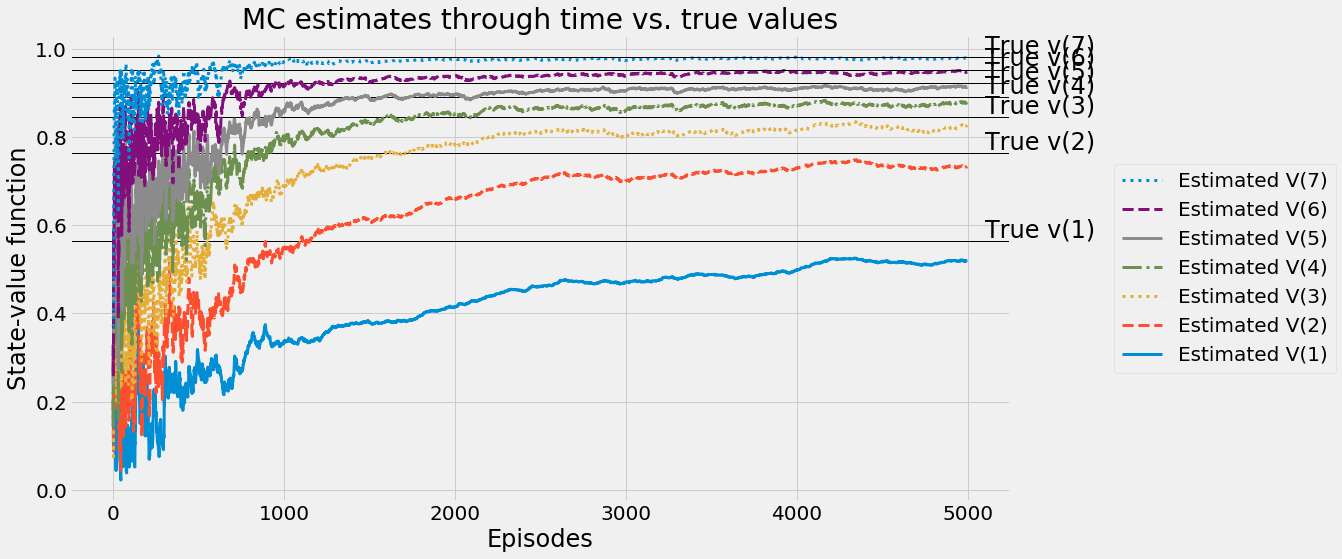

In [27]:
plot_value_function(
    'MC estimates through time vs. true values', 
    np.max(Q_track_mc, axis=2), 
    optimal_V, 
    log=False)

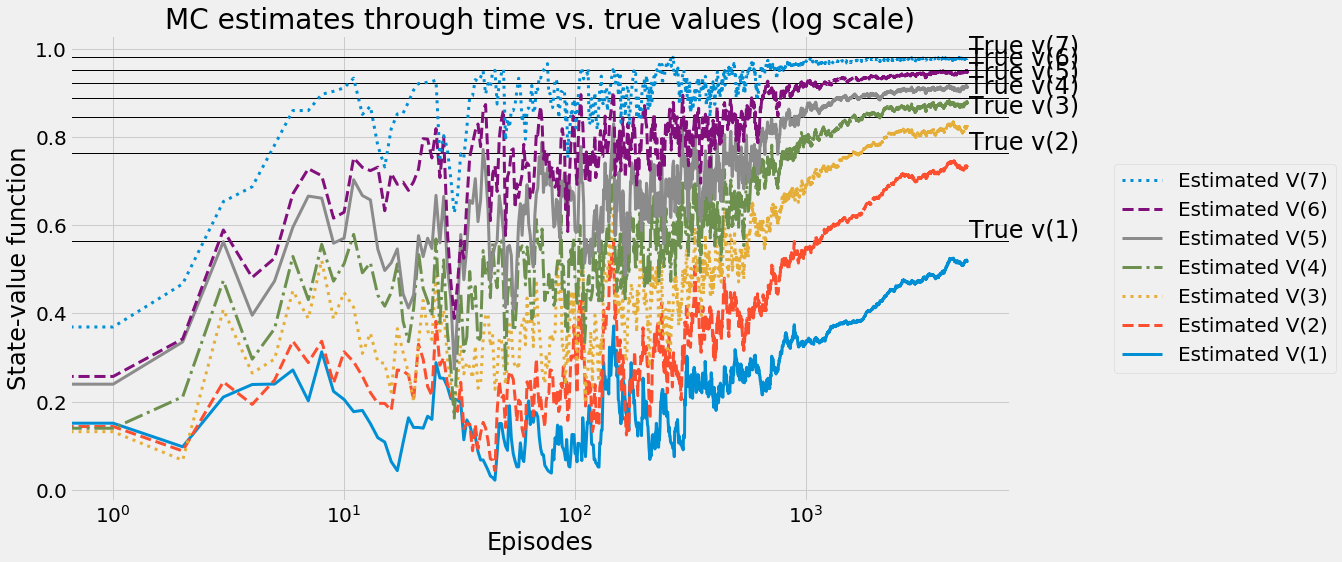

In [28]:
plot_value_function(
    'MC estimates through time vs. true values (log scale)', 
    np.max(Q_track_mc, axis=2), 
    optimal_V, 
    log=True)

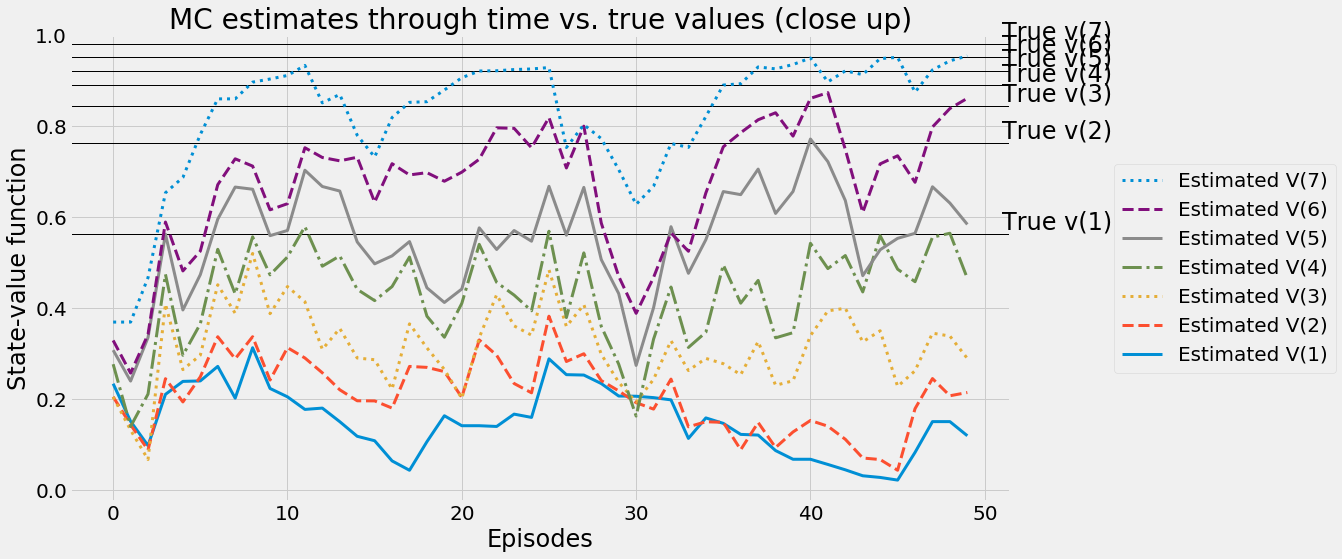

In [29]:
plot_value_function(
    'MC estimates through time vs. true values (close up)', 
    np.max(Q_track_mc, axis=2)[:50], 
    optimal_V[:50],
    log=False)

## SARSA

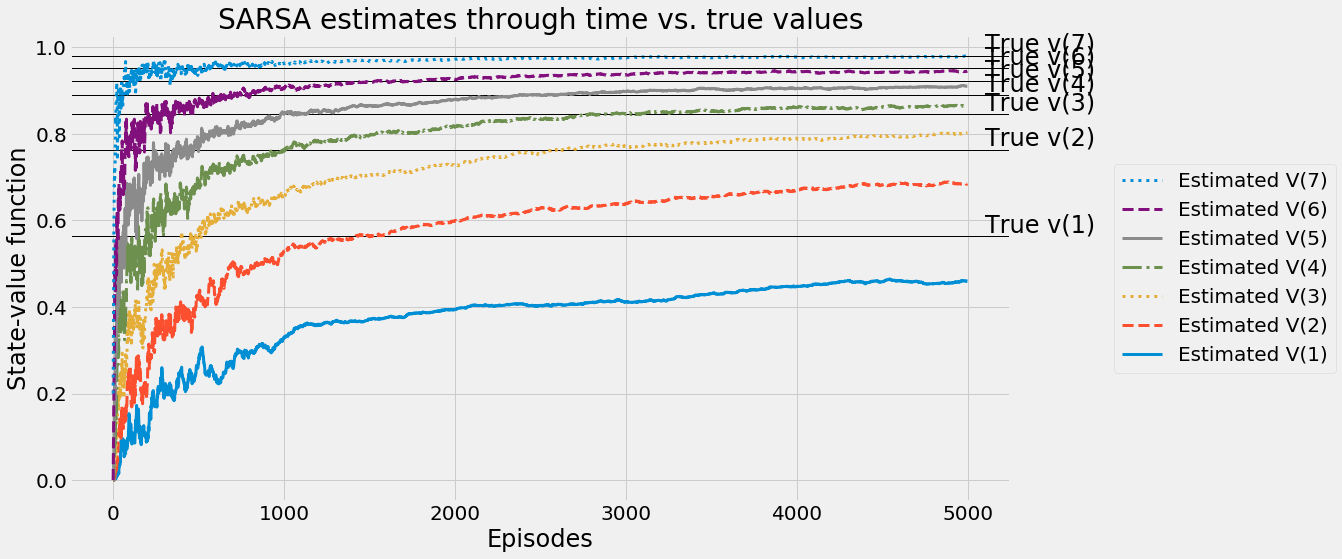

In [30]:
plot_value_function(
    'SARSA estimates through time vs. true values', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V, 
    log=False)

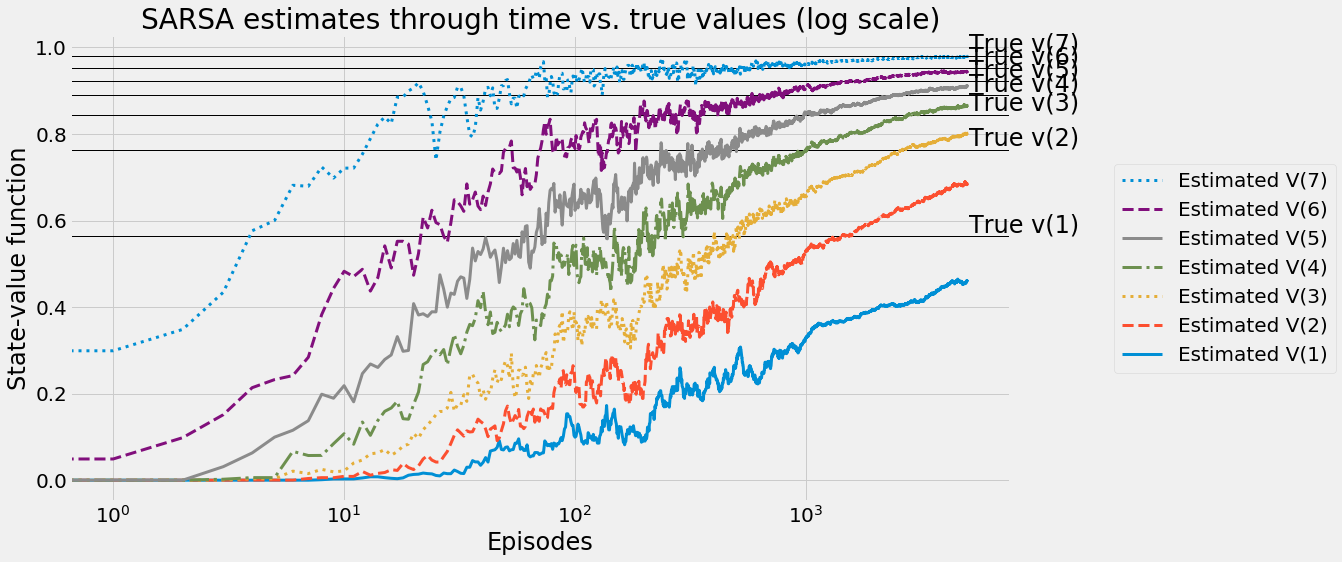

In [31]:
plot_value_function(
    'SARSA estimates through time vs. true values (log scale)', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V, 
    log=True)

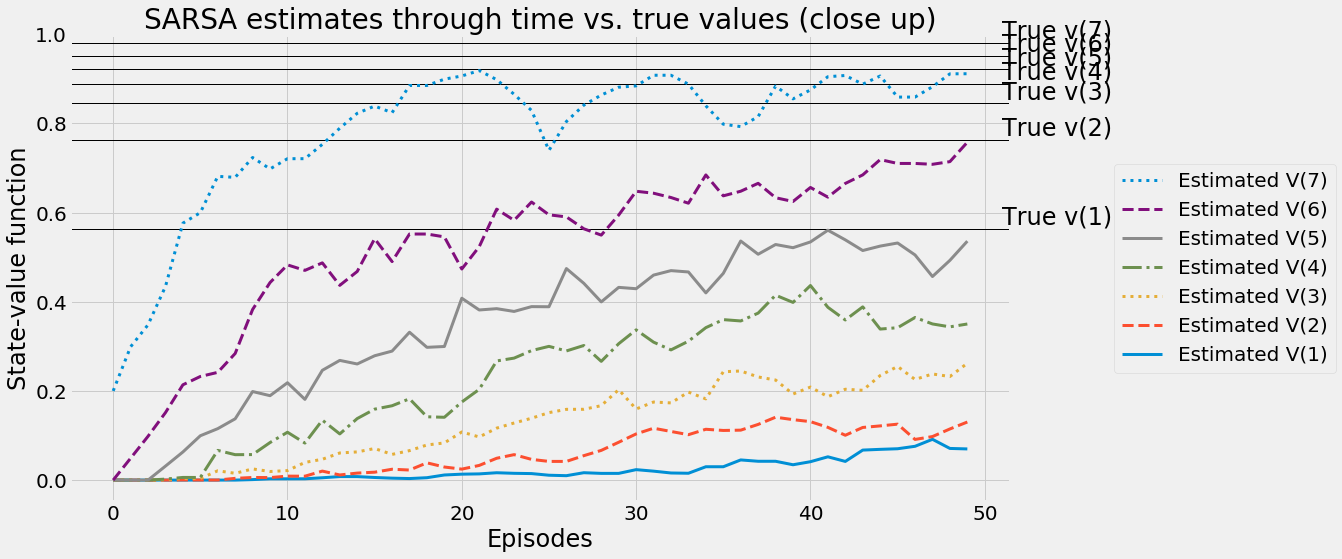

In [32]:
plot_value_function(
    'SARSA estimates through time vs. true values (close up)', 
    np.max(Q_track_sarsa, axis=2)[:50], 
    optimal_V[:50],
    log=False)

## Q-learning

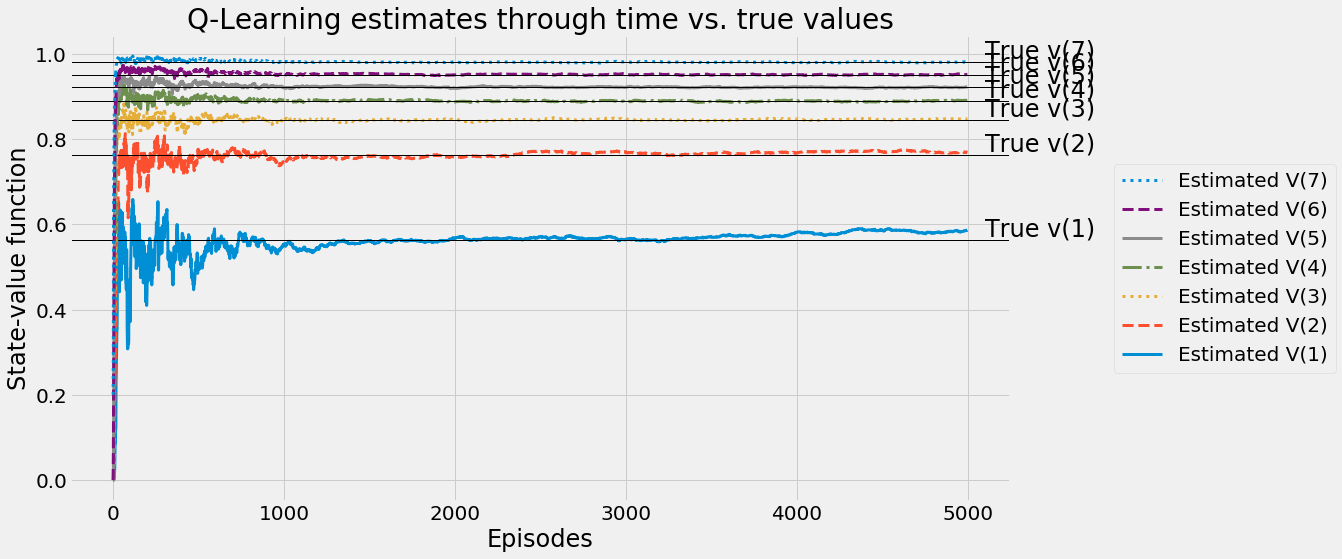

In [33]:
plot_value_function(
    'Q-Learning estimates through time vs. true values', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    log=False)

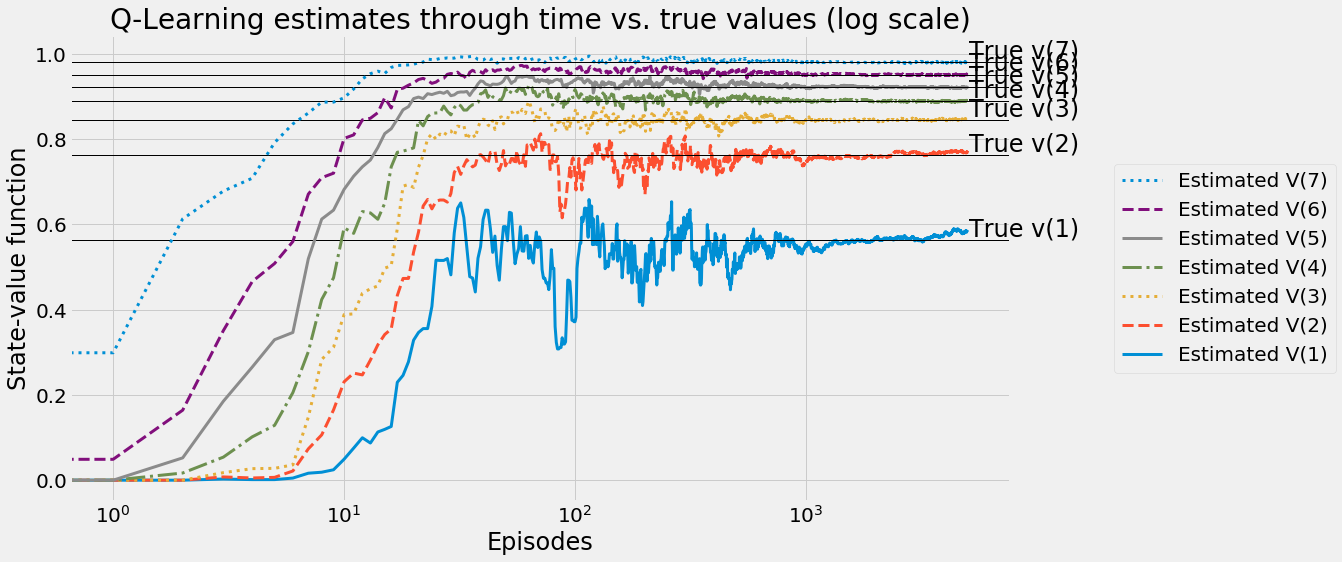

In [34]:
plot_value_function(
    'Q-Learning estimates through time vs. true values (log scale)', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    log=True)

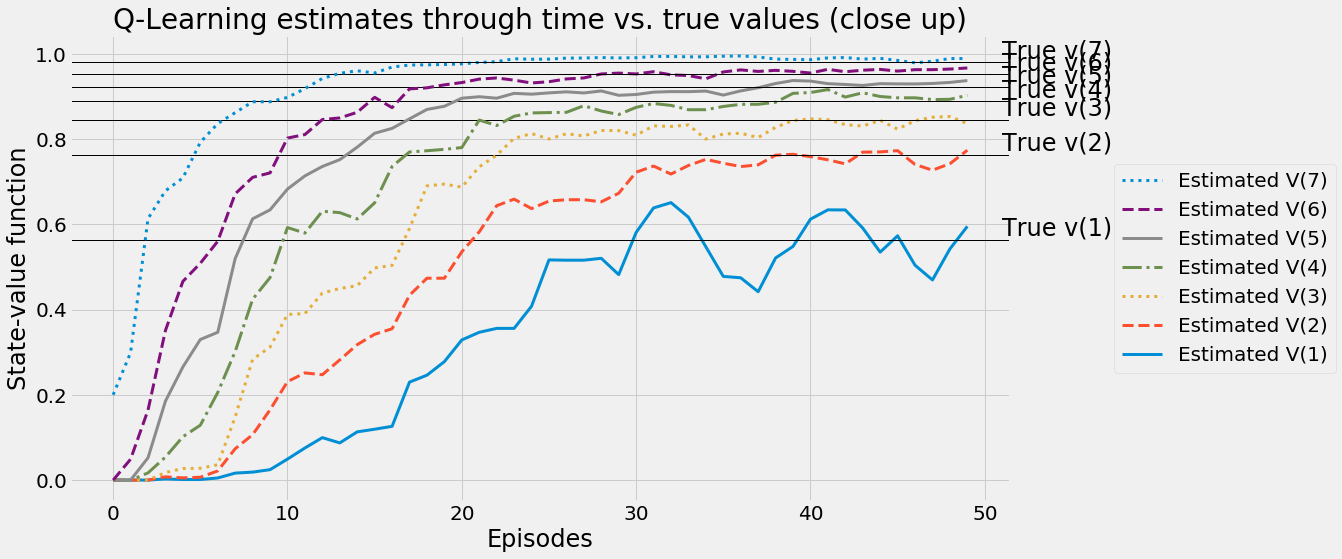

In [35]:
plot_value_function(
    'Q-Learning estimates through time vs. true values (close up)', 
    np.max(Q_track_ql, axis=2)[:50], 
    optimal_V[:50],
    log=False)

# Russell & Norvig's Gridworld

In [36]:
env = gym.make('RussellNorvigGridworld-v0')
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P)
print_state_value_function(optimal_V, P, n_cols=4, prec=4, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=4, 
                            title='Optimal action-value function:')
print()

print_policy(optimal_pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%. Obtains an average undiscounted return of {:.4f}.'.format(
    probability_success(env, optimal_pi, goal_state=3)*100, 
    mean_return(env, optimal_pi)))

Optimal state-value function:
| 00 0.8116 | 01 0.8678 | 02 0.9178 |           |
| 04 0.7616 |           | 06 0.6603 |           |
| 08 0.7053 | 09 0.6553 | 10 0.6114 | 11 0.3879 |

Optimal action-value function:
╒═════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      v │       > │       ^ │
╞═════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0.7666 │ 0.7372 │  0.8116 │  0.7772 │
├─────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.7828 │ 0.8272 │  0.8678 │  0.8272 │
├─────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.8121 │ 0.675  │  0.9178 │  0.881  │
├─────┼────────┼────────┼─────────┼─────────┤
│   3 │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼─────────┼─────────┤
│   4 │ 0.7209 │ 0.6766 │  0.7209 │  0.7616 │
├─────┼────────┼────────┼─────────┼─────────┤
│   5 │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼─────────┼─────────┤
│   6 │ 0.6411 │ 0.4152 │ -0.6871 │  0.6603 │
├─────┼────────┼────────┼─────────┼─────────┤
│   7 

In [37]:
Q_mcs, V_mcs, Q_track_mcs = [], [], []
for seed in tqdm([12, 34, 56, 78, 90], desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = on_policy_mc_control(env)
    Q_mcs.append(Q_mc) ; V_mcs.append(V_mc) ; Q_track_mcs.append(Q_track_mc)
Q_mc, V_mc, Q_track_mc = np.mean(Q_mcs, axis=0), np.mean(V_mcs, axis=0), np.mean(Q_track_mcs, axis=0)

In [38]:
print_state_value_function(V_mc, P, n_cols=4, prec=3, title='State-value function found by MC:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='MC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_mc, goal_state=3)*100))

State-value function found by MC:
| 00  0.783 | 01  0.844 | 02  0.905 |           |
| 04  0.728 |           | 06  0.638 |           |
| 08  0.664 | 09  0.562 | 10  0.302 | 11 -0.296 |
Optimal state-value function:
| 00  0.812 | 01  0.868 | 02  0.918 |           |
| 04  0.762 |           | 06   0.66 |           |
| 08  0.705 | 09  0.655 | 10  0.611 | 11  0.388 |
State-value function errors:
| 00 -0.029 | 01 -0.023 | 02 -0.013 |           |
| 04 -0.034 |           | 06 -0.023 |           |
| 08 -0.041 | 09 -0.093 | 10 -0.309 | 11 -0.684 |
State-value function RMSE: 0.2192

MC action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╪═════════╪═════════╡
│   0 │  0.67 │  0.64 │  0.78 │  0.68 │  0.77 │  0.74 │  0.8

In [39]:
Q_sarsas, V_sarsas, Q_track_sarsas = [], [], []
for seed in tqdm([12, 34, 56, 78, 90], desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env)
    Q_sarsas.append(Q_sarsa) ; V_sarsas.append(V_sarsa) ; Q_track_sarsas.append(Q_track_sarsa)
Q_sarsa = np.mean(Q_sarsas, axis=0)
V_sarsa = np.mean(V_sarsas, axis=0)
Q_track_sarsa = np.mean(Q_track_sarsas, axis=0)

In [40]:
print_state_value_function(V_sarsa, P, n_cols=4, prec=3, title='State-value function found by SARSA:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='SARSA action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_sarsa, goal_state=3)*100))

State-value function found by SARSA:
| 00  0.765 | 01  0.835 | 02  0.909 |           |
| 04    0.7 |           | 06  0.621 |           |
| 08  0.613 | 09  0.514 | 10  0.105 | 11 -0.518 |
Optimal state-value function:
| 00  0.812 | 01  0.868 | 02  0.918 |           |
| 04  0.762 |           | 06   0.66 |           |
| 08  0.705 | 09  0.655 | 10  0.611 | 11  0.388 |
State-value function errors:
| 00 -0.046 | 01 -0.033 | 02 -0.009 |           |
| 04 -0.062 |           | 06 -0.039 |           |
| 08 -0.092 | 09 -0.142 | 10 -0.506 | 11 -0.906 |
State-value function RMSE: 0.3047

SARSA action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╪═════════╪═════════╡
│   0 │  0.63 │  0.58 │  0.77 │  0.65 │  0.77 │  0.74 

In [41]:
Q_qls, V_qls, Q_track_qls = [], [], []
for seed in tqdm([12, 34, 56, 78, 90], desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env)
    Q_qls.append(Q_ql) ; V_qls.append(V_ql) ; Q_track_qls.append(Q_track_ql)
Q_ql = np.mean(Q_qls, axis=0)
V_ql = np.mean(V_qls, axis=0)
Q_track_ql = np.mean(Q_track_qls, axis=0)

In [42]:
print_state_value_function(V_ql, P, n_cols=4, prec=3, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_ql, goal_state=3)*100))

State-value function found by Q-learning:
| 00  0.808 | 01  0.866 | 02  0.918 |           |
| 04  0.758 |           | 06  0.648 |           |
| 08  0.701 | 09  0.651 | 10   0.61 | 11  0.484 |
Optimal state-value function:
| 00  0.812 | 01  0.868 | 02  0.918 |           |
| 04  0.762 |           | 06   0.66 |           |
| 08  0.705 | 09  0.655 | 10  0.611 | 11  0.388 |
State-value function errors:
| 00 -0.004 | 01 -0.002 | 02   -0.0 |           |
| 04 -0.003 |           | 06 -0.012 |           |
| 08 -0.004 | 09 -0.004 | 10 -0.001 | 11  0.096 |
State-value function RMSE: 0.028

Q-learning action-value function:
╒═════╤══════╤══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │    < │    v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪══════╪══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╪═════════╪═════════╡
│   0 │ 0.77 │ 0.74 │  0.81 │  0.78 │  0.77 │  0.74

# FrozenLake environment

In [43]:
env = gym.make('FrozenLake-v0')
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=0.99)
print_state_value_function(optimal_V, P, n_cols=4, prec=4, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=4, 
                            title='Optimal action-value function:')
print()

print_policy(optimal_pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%. Obtains an average undiscounted return of {:.4f}.'.format(
    probability_success(env, optimal_pi, goal_state=15)*100, 
    mean_return(env, optimal_pi)))

Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |

Optimal action-value function:
╒═════╤════════╤════════╤════════╤════════╕
│   s │      < │      v │      > │      ^ │
╞═════╪════════╪════════╪════════╪════════╡
│   0 │ 0.542  │ 0.5278 │ 0.5278 │ 0.5223 │
├─────┼────────┼────────┼────────┼────────┤
│   1 │ 0.3435 │ 0.3342 │ 0.3199 │ 0.4988 │
├─────┼────────┼────────┼────────┼────────┤
│   2 │ 0.4382 │ 0.4336 │ 0.4243 │ 0.4707 │
├─────┼────────┼────────┼────────┼────────┤
│   3 │ 0.3061 │ 0.3061 │ 0.3015 │ 0.4569 │
├─────┼────────┼────────┼────────┼────────┤
│   4 │ 0.5585 │ 0.3796 │ 0.3742 │ 0.3632 │
├─────┼────────┼────────┼────────┼────────┤
│   5 │ 0      │ 0      │ 0      │ 0      │
├─────┼────────┼────────┼────────┼────────┤
│   6 │ 0.3583 │ 0.203  │ 0.3583 │ 0.1553 │
├─────┼────────┼────────┼────────┼

In [44]:
Q_mcs, V_mcs, Q_track_mcs = [], [], []
for seed in tqdm([12, 34, 56, 78, 90], desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = on_policy_mc_control(env, gamma=0.99, n_episodes=20000)
    Q_mcs.append(Q_mc) ; V_mcs.append(V_mc) ; Q_track_mcs.append(Q_track_mc)
Q_mc, V_mc, Q_track_mc = np.mean(Q_mcs, axis=0), np.mean(V_mcs, axis=0), np.mean(Q_track_mcs, axis=0)

In [45]:
print_state_value_function(V_mc, P, n_cols=4, prec=3, title='State-value function found by MC:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='MC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_mc, goal_state=15)*100))

State-value function found by MC:
| 00  0.278 | 01  0.217 | 02  0.196 | 03  0.149 |
| 04  0.287 |           | 06  0.202 |           |
| 08  0.335 | 09  0.435 | 10  0.452 |           |
|           | 13  0.587 | 14  0.768 |           |
Optimal state-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |
State-value function errors:
| 00 -0.264 | 01 -0.281 | 02 -0.274 | 03 -0.308 |
| 04 -0.271 |           | 06 -0.157 |           |
| 08 -0.257 | 09 -0.208 | 10 -0.163 |           |
|           | 13 -0.155 | 14 -0.094 |           |
State-value function RMSE: 0.1913

MC action-value function:
╒═════╤══════╤══════╤══════╤══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │    < │    v │    > │    ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪══════╪══════╪══════╪══

In [46]:
Q_sarsas, V_sarsas, Q_track_sarsas = [], [], []
for seed in tqdm([12, 34, 56, 78, 90], desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env, gamma=0.99, n_episodes=20000)
    Q_sarsas.append(Q_sarsa) ; V_sarsas.append(V_sarsa) ; Q_track_sarsas.append(Q_track_sarsa)
Q_sarsa = np.mean(Q_sarsas, axis=0)
V_sarsa = np.mean(V_sarsas, axis=0)
Q_track_sarsa = np.mean(Q_track_sarsas, axis=0)

In [47]:
print_state_value_function(V_sarsa, P, n_cols=4, prec=3, title='State-value function found by SARSA:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='SARSA action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_sarsa, goal_state=15)*100))

State-value function found by SARSA:
| 00    0.3 | 01  0.248 | 02  0.217 | 03  0.147 |
| 04  0.319 |           | 06  0.215 |           |
| 08  0.368 | 09  0.464 | 10  0.467 |           |
|           | 13  0.596 | 14  0.782 |           |
Optimal state-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |
State-value function errors:
| 00 -0.242 | 01 -0.251 | 02 -0.254 | 03  -0.31 |
| 04 -0.239 |           | 06 -0.144 |           |
| 08 -0.224 | 09 -0.179 | 10 -0.148 |           |
|           | 13 -0.146 | 14 -0.081 |           |
State-value function RMSE: 0.1753

SARSA action-value function:
╒═════╤══════╤══════╤══════╤══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │    < │    v │    > │    ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪══════╪══════╪═══

In [48]:
Q_qls, V_qls, Q_track_qls = [], [], []
for seed in tqdm([12, 34, 56, 78, 90], desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env, gamma=0.99, n_episodes=20000)
    Q_qls.append(Q_ql) ; V_qls.append(V_ql) ; Q_track_qls.append(Q_track_ql)
Q_ql = np.mean(Q_qls, axis=0)
V_ql = np.mean(V_qls, axis=0)
Q_track_ql = np.mean(Q_track_qls, axis=0)

In [49]:
print_state_value_function(V_ql, P, n_cols=4, prec=3, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_ql, goal_state=15)*100))

State-value function found by Q-learning:
| 00  0.531 | 01  0.483 | 02  0.451 | 03  0.437 |
| 04  0.549 |           | 06  0.358 |           |
| 08  0.582 | 09  0.636 | 10  0.611 |           |
|           | 13  0.731 | 14  0.854 |           |
Optimal state-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |
State-value function errors:
| 00 -0.011 | 01 -0.016 | 02  -0.02 | 03  -0.02 |
| 04  -0.01 |           | 06   -0.0 |           |
| 08 -0.009 | 09 -0.007 | 10 -0.004 |           |
|           | 13 -0.011 | 14 -0.008 |           |
State-value function RMSE: 0.01

Q-learning action-value function:
╒═════╤══════╤══════╤══════╤══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │    < │    v │    > │    ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪══════╪══

# Policy evolution comparison

In [50]:
mc_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=15, iterations=10)*100 for pi in tqdm(pi_track_mc)])

In [51]:
sarsa_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=15, iterations=10)*100 for pi in tqdm(pi_track_sarsa)])

In [52]:
ql_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=15, iterations=10)*100 for pi in tqdm(pi_track_ql)])

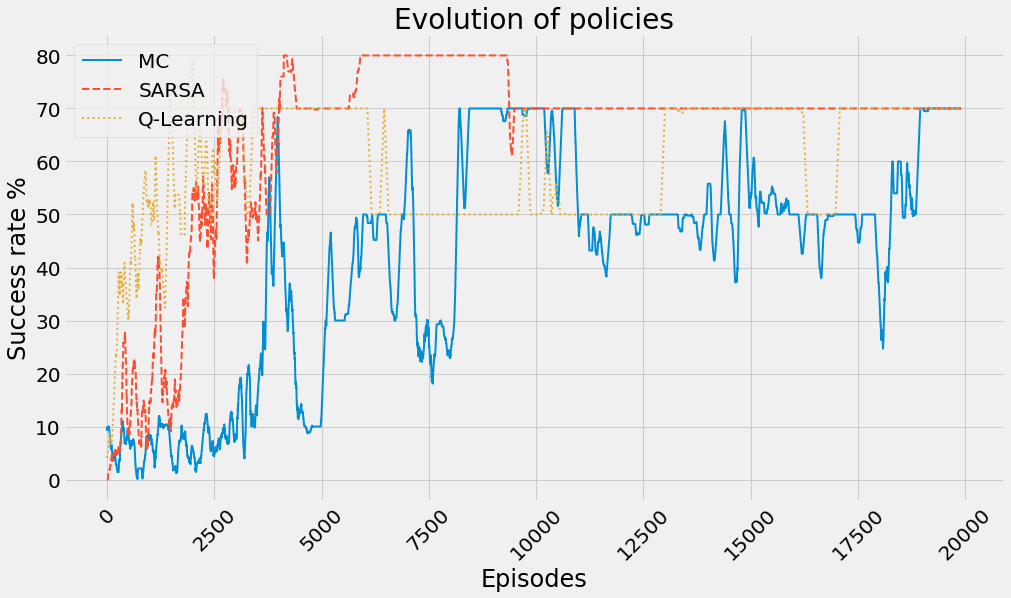

In [53]:
plt.plot(mc_success_evolution, '-', linewidth=2, label='MC')
plt.plot(sarsa_success_evolution, '--', linewidth=2, label='SARSA')
plt.plot(ql_success_evolution, ':', linewidth=2, label='Q-Learning')
plt.legend(loc=2, ncol=1)

plt.title('Evolution of policies')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.xticks(rotation=45)

plt.show()

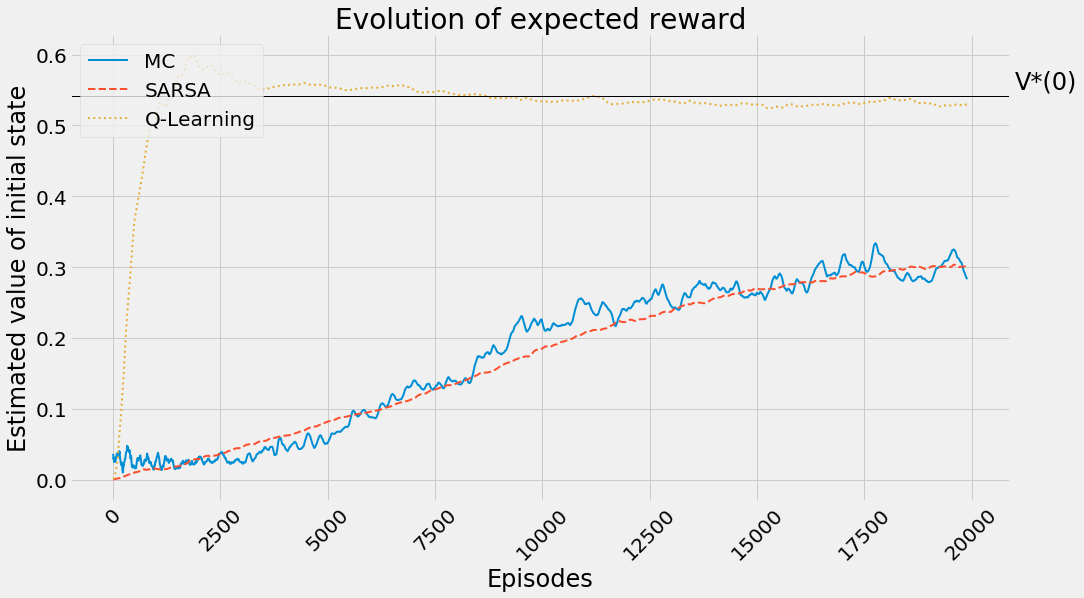

In [54]:
plt.plot(moving_average(np.max(Q_track_mc, axis=2).T[0]), 
         '-', linewidth=2, label='MC')
plt.plot(moving_average(np.max(Q_track_sarsa, axis=2).T[0]), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.max(Q_track_ql, axis=2).T[0]), 
         ':', linewidth=2, label='Q-Learning')
plt.legend(loc=2, ncol=1)

plt.axhline(y=optimal_V[0], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_mc)*1.05), optimal_V[0]+.01, 'V*(0)')


plt.title('Evolution of expected reward')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state')
plt.xticks(rotation=45)

plt.show()

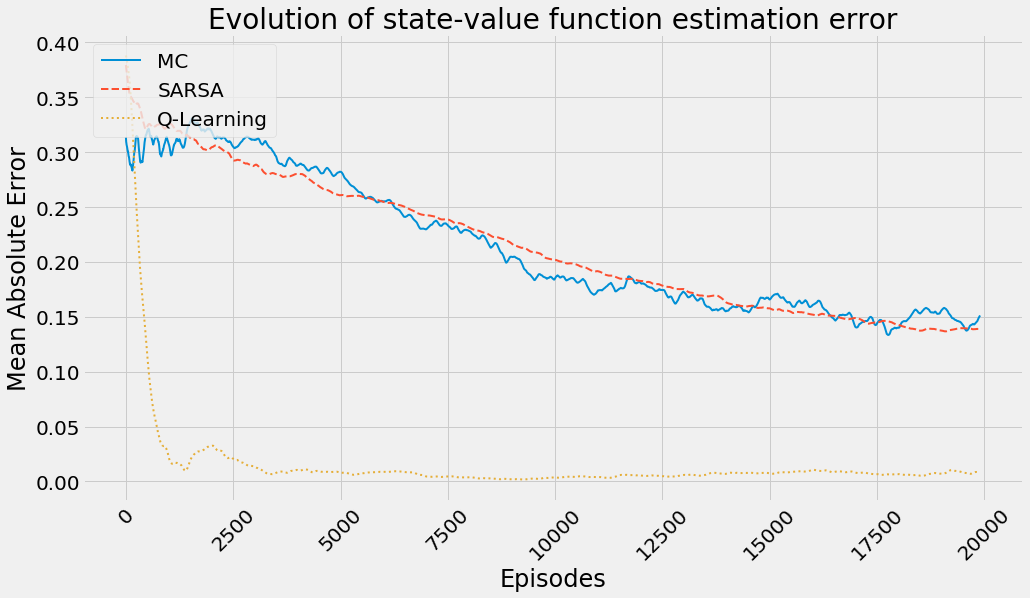

In [55]:
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_mc, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='MC')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_sarsa, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_ql, axis=2) - optimal_V), axis=1)), 
         ':', linewidth=2, label='Q-Learning')
plt.legend(loc=2, ncol=1)

plt.title('Evolution of state-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

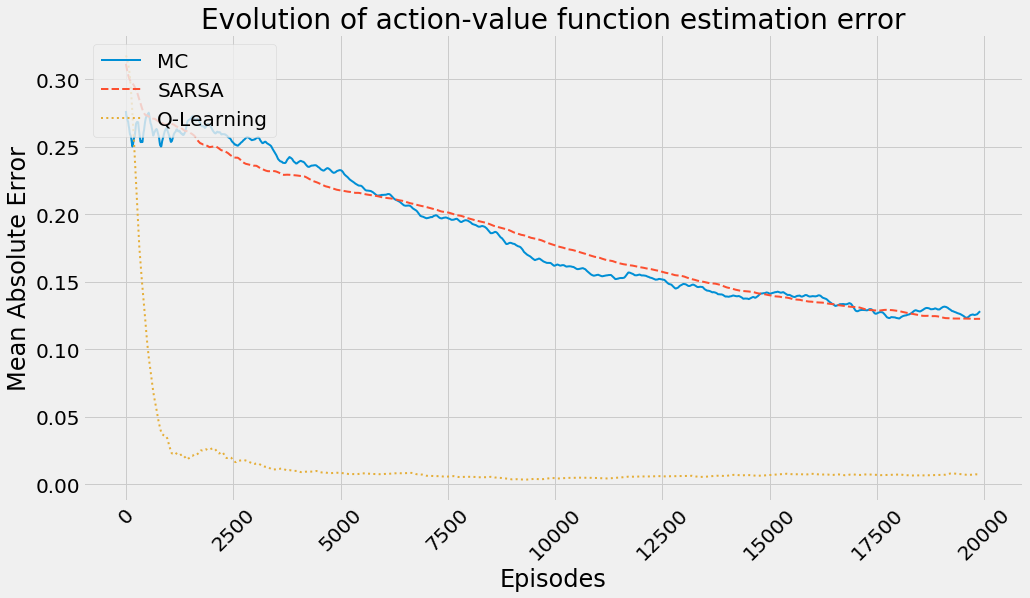

In [56]:
plt.plot(moving_average(np.mean(np.abs(Q_track_mc - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='MC')
plt.plot(moving_average(np.mean(np.abs(Q_track_sarsa - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.mean(np.abs(Q_track_ql - optimal_Q), axis=(1,2))), 
         ':', linewidth=2, label='Q-Learning')
plt.legend(loc=2, ncol=1)

plt.title('Evolution of action-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

In [57]:
mc_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_mc)])

In [58]:
sarsa_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_sarsa)])

In [59]:
ql_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_ql)])

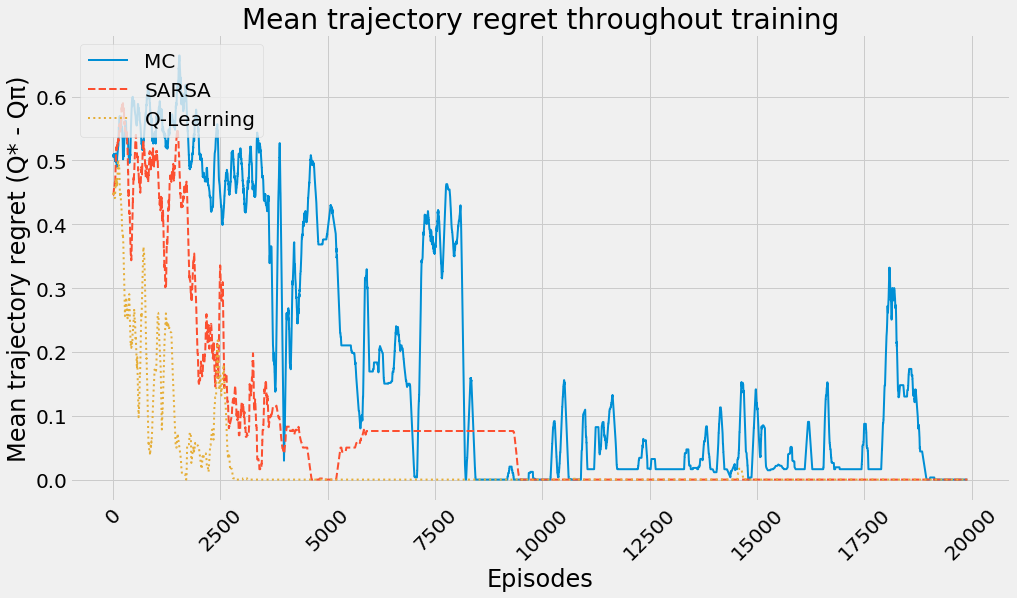

In [60]:
plt.plot(mc_regret_accumulation, '-', linewidth=2, label='MC')
plt.plot(sarsa_regret_accumulation, '--', linewidth=2, label='SARSA')
plt.plot(ql_regret_accumulation, ':', linewidth=2, label='Q-Learning')
plt.legend(loc=2, ncol=1)

plt.title('Mean trajectory regret throughout training')
plt.xlabel('Episodes')
plt.ylabel('Mean trajectory regret (Q* - Qπ)')
plt.xticks(rotation=45)

plt.show()

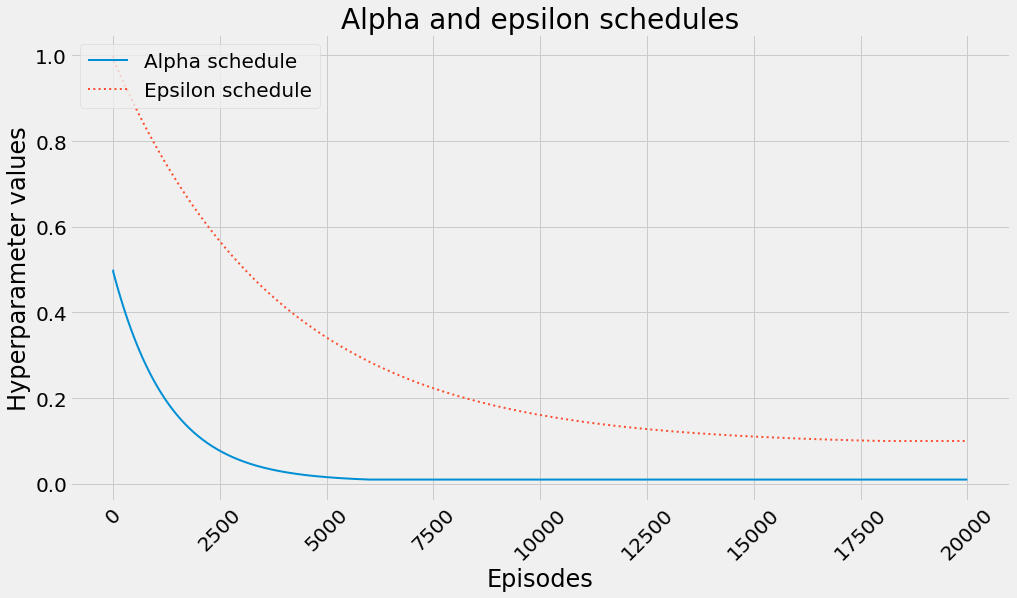

In [61]:
plt.plot([decay_schedule(0.5, 0.01, 0.3, 20000, i) for i in range(20000)], '-', linewidth=2, label='Alpha schedule')
plt.plot([decay_schedule(1.0, 0.1, 0.9, 20000, i) for i in range(20000)], ':', linewidth=2, label='Epsilon schedule')
plt.legend(loc=2, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()